## BREAST CANCER PRINCIPAL COMPONENT ANALYSIS
    
   #### Load  the required libraries
   #### also ensure the kernel is _mxnet

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [2]:
# sagemaker libraries
import boto3
import sagemaker

#### Set up the Sagemaker environment

In [3]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::396358375665:role/service-role/AmazonSageMaker-ExecutionRole-20200814T112856


In [4]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)

sagemaker-eu-west-1-396358375665


#### Read in the standardised data

In [5]:
# read in the csv file
local_data = 'data/scaled.csv'

# print out some data
scaled_bc_df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', scaled_bc_df.shape)
print()
scaled_bc_df.head()

Data shape (rows, cols):  (569, 33)



,Unnamed: 0,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diag_value
0,0,842302,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,1,842517,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,2,84300903,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,3,84348301,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,4,84358402,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


In [6]:
scaled_bc_df = scaled_bc_df.drop('Unnamed: 0', axis = 1)
scaled_bc_df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diag_value
0,842302,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,842517,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,84300903,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,84348301,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,84358402,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


#### create the features only dataset

In [7]:
features_df = scaled_bc_df.drop(['id', 'diag_value'], axis = 1)
print('Features shape (rows, cols): ', features_df.shape)

Features shape (rows, cols):  (569, 30)


#### define the model

In [8]:
# define location to store model artifacts
prefix = 'bc_pca'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-eu-west-1-396358375665/bc_pca/


In [9]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1

N_COMPONENTS=29

pca_bc = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


#### Convert the data into Recordset format

In [10]:
# convert df to np array
features_np = features_df.values.astype('float32')

# convert to RecordSet format
formatted_bc_data = pca_bc.record_set(features_np)

#### Train the model

In [11]:
%%time

# train the PCA model on the formatted data
pca_bc.fit(formatted_bc_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-08 17:27:25 Starting - Starting the training job...
2020-10-08 17:27:26 Starting - Launching requested ML instances......
2020-10-08 17:28:26 Starting - Preparing the instances for training.........
2020-10-08 17:30:10 Downloading - Downloading input data
2020-10-08 17:30:10 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/08/2020 17:30:35 INFO 139784377546560] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/08/2020 17:30:35 INFO 139784377546560] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'30', u'mini_batch_size': u'500', u'num_comp

#### check the model attributes

In [12]:
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2020-10-08-17-27-25-060'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

bc_pca/pca-2020-10-08-17-27-25-060/output/model.tar.gz


2304

In [13]:
import mxnet as mx

In [14]:
# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[ 0.6527885   0.95096016  1.9815059   2.1570976   2.9679654   3.2052093
  3.721546    3.9513304   4.1297145   4.210665    5.305917    5.471752
  5.8136115   6.741065    7.318657    9.451905   11.718893   12.190194
 12.932054   14.126024   15.401726   16.468004   19.601027   26.210417
 30.62887    33.570587   40.04264    56.906773   86.93236   ]
<NDArray 29 @cpu(0)>, 'v': 
[[ 2.11507991e-01  2.11173698e-01  1.31506681e-01  1.29473299e-01
  -1.92302298e-02 -1.82578057e-01 -9.85514596e-02 -7.29291737e-02
  -6.85682818e-02 -4.96994518e-02 -2.25383371e-01  1.46710292e-01
   2.02924281e-01  1.50584459e-01 -5.11187688e-02 -5.95058687e-02
   1.19670443e-02  5.10675386e-02  4.14713807e-02 -9.54863951e-02
   2.23109767e-01 -7.45229097e-03  1.24088429e-01 -1.87408067e-02
   3.77863571e-02 -4.14089598e-02  8.53122585e-03  2.33857140e-01
  -2.18902439e-01]
 [-1.05339261e-02 -6.44833490e-05  1.73550323e-02  2.45579984e-02
   8.47459361e-02  9.87880304e-02 -5.53710444e-04 -9.48001742e-02
   4.

#### check on the variance to help select the number of components 
   the parament s gives the variance  
   the paramter v gives the component detail
    
   In order get the highest variance you need to start at the end of s

In [15]:
# get selected params
s = pd.DataFrame(pca_model_params['s'].asnumpy())
v = pd.DataFrame(pca_model_params['v'].asnumpy())

#### calculate the explained variance

to calculate the explained variance for the top N components, calculate s squared for *each* of the top N components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{N}^{ } s_n^2}{\sum s^2}
\end{equation*}

In [16]:
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 29-3 = 26, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [22]:
for i in range(N_COMPONENTS):
    eVar = explained_variance(s,i)
    print('Top' + str(i) + ' components explain ' + str(eVar) + ' of the variance')



Top0 components explain 0.0 of the variance
Top1 components explain 0.44272223 of the variance
Top2 components explain 0.6324349 of the variance
Top3 components explain 0.726367 of the variance
Top4 components explain 0.7923886 of the variance
Top5 components explain 0.84734654 of the variance
Top6 components explain 0.88759196 of the variance
Top7 components explain 0.9100994 of the variance
Top8 components explain 0.92598665 of the variance
Top9 components explain 0.9398833 of the variance
Top10 components explain 0.951573 of the variance
Top11 components explain 0.9613703 of the variance
Top12 components explain 0.9700757 of the variance
Top13 components explain 0.978121 of the variance
Top14 components explain 0.9833546 of the variance
Top15 components explain 0.98649246 of the variance
Top16 components explain 0.9891547 of the variance
Top17 components explain 0.9911346 of the variance
Top18 components explain 0.9928886 of the variance
Top19 components explain 0.9945379 of the var

#### Component Makeup

We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**.

In [23]:
# features
features_list = features_df.columns.values
print('Features: \n', features_list)

Features: 
 ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean'
 'radius_se' 'texture_se' 'perimeter_se' 'area_se' 'smoothness_se'
 'compactness_se' 'concavity_se' 'concave points_se' 'symmetry_se'
 'fractal_dimension_se' 'radius_worst' 'texture_worst' 'perimeter_worst'
 'area_worst' 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst']


In [33]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(6,4))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

The 7 top components explain 91% of the variance

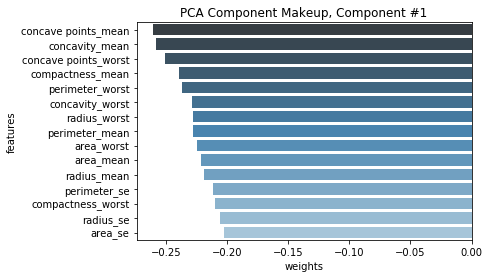

In [39]:
# display makeup of last component - most variance 
num=1
display_component(v, features_list, component_num=num, n_weights=15)

1. Concavity component

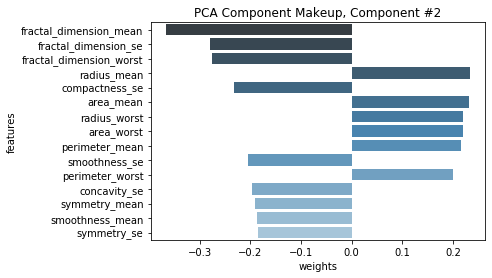

In [40]:
num=2
display_component(v, features_list, component_num=num, n_weights=15)

2. Size and Jaggedness

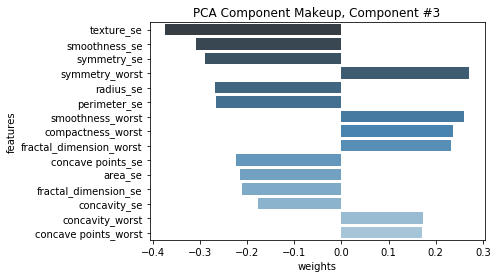

In [44]:
num=3
display_component(v, features_list, component_num=num, n_weights=15)

3. Smoothness and symmetry

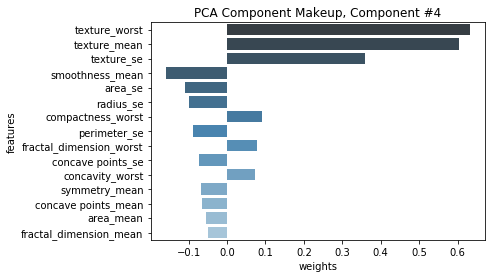

In [45]:
num=4
display_component(v, features_list, component_num=num, n_weights=15)

4. Texture

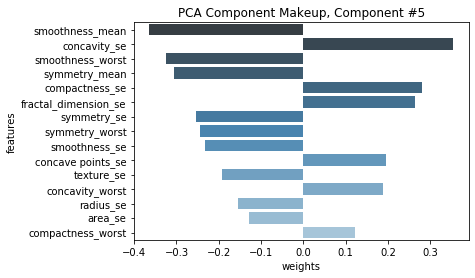

In [46]:
num=5
display_component(v, features_list, component_num=num, n_weights=15)

5. Smooth and Symmetrical

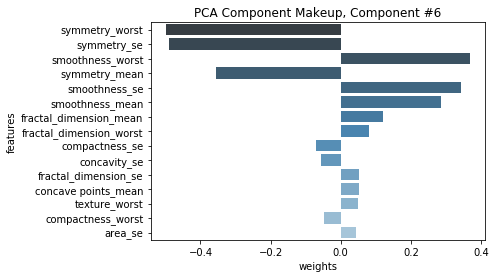

In [49]:
num=6
display_component(v, features_list, component_num=num, n_weights=15)

6. Symmetry and smootheness

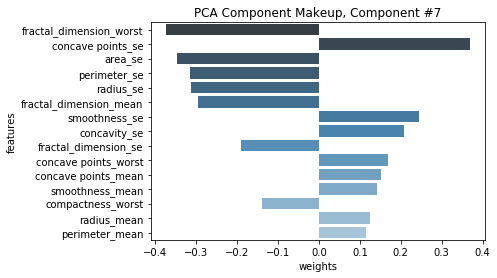

In [48]:
num=7
display_component(v, features_list, component_num=num, n_weights=15)

6. Irregularity

#### Deploy the model
We will deploy to obtain components to the features dataset used to train the PCA

In [50]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_bc.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 307 ms, sys: 4.76 ms, total: 312 ms
Wall time: 8min 33s


In [51]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(features_np)

In [52]:
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.045646052807569504
      values: -0.03391718864440918
      values: 0.2525694966316223
      values: 0.20152251422405243
      values: 0.15101824700832367
      values: 0.1752556711435318
      values: 0.08452287316322327
      values: -0.06884904205799103
      values: 0.09651646018028259
      values: 0.3455643355846405
      values: -0.13376647233963013
      values: -0.5495595932006836
      values: -0.2654690146446228
      values: -0.7451176643371582
      values: 0.6017934679985046
      values: 0.6908040046691895
      values: 0.10338763892650604
      values: -0.8590150475502014
      values: 0.26295581459999084
      values: 0.8774019479751587
      values: 0.15711840987205505
      values: -0.3984059691429138
      values: -2.159369945526123
      values: -1.4114243984222412
      values: -1.1951102018356323
      values: -3.633730888366699
      values: 1.1231664419174194
      values: -1.94858312606

#### Create a transformed DataFrame

For each of our data points, get the top n component values from the list of component data points, returned by our predictor above, and put those into a new DataFrame.

In [53]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, features_data, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param features_data: A dataframe of normalised/standardised, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    bc_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        bc_transformed=bc_transformed.append([list(components)])

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    bc_transformed = bc_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return bc_transformed.iloc[:, ::-1]

In [54]:
# specify top n
top_n = 7

# call your function and create a new dataframe
bc_transformed = create_transformed_df(train_pca, features_df, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
bc_transformed.columns=PCA_list 

# print result
bc_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
0,-9.192838,-1.948583,1.123166,-3.633731,-1.195110,-1.411424,-2.159370
0,-2.387802,3.768172,0.529293,-1.118264,0.621775,-0.028657,-0.013358
0,-5.733896,1.075174,0.551748,-0.912083,-0.177086,-0.541452,0.668167
0,-7.122953,-10.275589,3.232790,-0.152547,-2.960879,-3.053421,-1.429910
0,-3.935302,1.948071,-1.389767,-2.940639,0.546748,1.226494,0.936212


#### Create the PCA dataset to be used for modelling

In [57]:
bc_transformed.shape

(569, 7)

In [60]:
scaled_bc_df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diag_value
0,842302,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,842517,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,84300903,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,84348301,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,84358402,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


In [58]:
scaled_bc_df.shape

(569, 32)

In [66]:
pca_bc_df = pd.concat([scaled_bc_df['id'], 
                      scaled_bc_df['diag_value']], axis = 1, ignore_index = True, sort = False)
pca_bc_df.head()

,0,1
0,842302,1
1,842517,1
2,84300903,1
3,84348301,1
4,84358402,1


In [67]:
pca_bc_df.reset_index(drop=True, inplace=True)
bc_transformed.reset_index(drop=True, inplace=True)

In [68]:
pca_final_bc_df = pd.concat( [pca_bc_df, bc_transformed], axis=1) 
pca_final_bc_df.head()

,0,1,c_1,c_2,c_3,c_4,c_5,c_6,c_7
0,842302,1,-9.192838,-1.948583,1.123166,-3.633731,-1.195110,-1.411424,-2.159370
1,842517,1,-2.387802,3.768172,0.529293,-1.118264,0.621775,-0.028657,-0.013358
2,84300903,1,-5.733896,1.075174,0.551748,-0.912083,-0.177086,-0.541452,0.668167
3,84348301,1,-7.122953,-10.275589,3.232790,-0.152547,-2.960879,-3.053421,-1.429910
4,84358402,1,-3.935302,1.948071,-1.389767,-2.940639,0.546748,1.226494,0.936212


In [69]:
final_list=['id','diag_value','c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
pca_final_bc_df.columns=final_list
pca_final_bc_df.head()

,id,diag_value,c_1,c_2,c_3,c_4,c_5,c_6,c_7
0,842302,1,-9.192838,-1.948583,1.123166,-3.633731,-1.195110,-1.411424,-2.159370
1,842517,1,-2.387802,3.768172,0.529293,-1.118264,0.621775,-0.028657,-0.013358
2,84300903,1,-5.733896,1.075174,0.551748,-0.912083,-0.177086,-0.541452,0.668167
3,84348301,1,-7.122953,-10.275589,3.232790,-0.152547,-2.960879,-3.053421,-1.429910
4,84358402,1,-3.935302,1.948071,-1.389767,-2.940639,0.546748,1.226494,0.936212


#### write the PCA dataset locally for use with modelling notebooks

In [70]:
pca_data = 'data/pca.csv'
pca_final_bc_df.to_csv(pca_data)